In [17]:
import CalculatedFieldSubroutines as cfs

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from pandasgui import show

import matplotlib.pyplot as plt

import seaborn as sns

import warnings

In [18]:
warnings.filterwarnings( 'ignore' )

In [19]:
gmID_list = cfs.list_whitelisted_gmIDs()

topic_list = cfs.list_topics()

print( topic_list )

AttributeError: module 'CalculatedFieldSubroutines' has no attribute 'list_whitelisted_gmIDs'

,brakePercentage,groupMetadataID,drivingMode,speedMps,time,throttlePercentage,steeringPercentage,signal.turnSignal,BinaryDrivingMode
0,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301113165469,0.0,-34.701275,TURN_NONE,0
1,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301145044093,0.0,-34.701275,TURN_NONE,0
2,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301187896638,0.0,-34.701275,TURN_NONE,0
3,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301211437749,0.0,-34.701275,TURN_NONE,0
4,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301254799428,0.0,-34.701275,TURN_NONE,0


In [155]:
features = [  'speedMps', 'throttlePercentage','steeringPercentage', 'brakePercentage', 'BinaryDrivingMode']
#created a selection on variables/column that I believed were important and wanted to use

In [76]:
data = best_pose[features].copy()
#creates a copy of the original data with on the subset features and columns I wanted 

In [77]:
data
#show the data

,speedMps,throttlePercentage,steeringPercentage,brakePercentage
0,0.00,0.0,-34.701275,0.0
1,0.00,0.0,-34.701275,0.0
2,0.00,0.0,-34.701275,0.0
3,0.00,0.0,-34.701275,0.0
4,0.00,0.0,-34.701275,0.0
...,...,...,...,...
53202,15.19,12.7,0.744368,0.0
53203,15.18,13.4,0.871694,0.0
53204,15.18,13.8,0.871694,0.0
53205,15.18,13.8,0.871694,0.0


In [78]:
data = ((data - data.min())/(data.max()-data.min())) * 9 + 1
#minimize the data to be able to ensure no column is prioritized over another.

In [79]:
data.describe()
#you can see that my minimum is now 1 and maximum is now 10

,speedMps,throttlePercentage,steeringPercentage,brakePercentage
count,53207.000000,53207.000000,53207.000000,53207.000000
mean,5.767008,2.050217,6.031918,1.722354
std,2.573871,1.238102,0.554716,1.530335
min,1.000000,1.000000,1.000000,1.000000
25%,4.041297,1.000000,6.025518,1.000000
50%,6.195382,1.857623,6.056836,1.000000
75%,7.438277,2.654709,6.087204,1.000000
max,10.000000,10.000000,10.000000,10.000000


In [80]:
data.head()

,speedMps,throttlePercentage,steeringPercentage,brakePercentage
0,1.0,1.0,4.380398,1.0
1,1.0,1.0,4.380398,1.0
2,1.0,1.0,4.380398,1.0
3,1.0,1.0,4.380398,1.0
4,1.0,1.0,4.380398,1.0


In [81]:
def random_centroids(data,k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)
#a function that will take in the number of clusters we want with our data
#initialize a list called centroids for i in range k
#then add it to the list of centroids
#the number of centroids is equivalent to the number of clusters we want
#combines all of the centroids(individual pandas series) into a data frame

In [82]:
centroids = random_centroids(data,5)
#we can now run the random_centroids

/tmp/ipykernel_31697/973749533.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  centroid = data.apply(lambda x: float(x.sample()))


In [83]:
centroids

,0,1,2,3,4
speedMps,7.334369,7.710036,2.598579,7.374334,7.602131
throttlePercentage,1.827354,1.000000,1.000000,2.422646,1.252242
steeringPercentage,6.067275,6.090526,6.269415,5.853272,3.462224
brakePercentage,3.562278,5.590747,1.000000,1.000000,1.000000


In [84]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)
#label each data point 
#finds the euclidean distance between a data point and each cluster for all centroids 
#finding which cluster center is closest to that point 

In [85]:
labels = get_labels(data, centroids)

In [86]:
labels.value_counts()
#how many times each value occurs 

3    33984
2    15453
0     3116
1      654
Name: count, dtype: int64

In [87]:
def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids
#splits the data by each cluster and then calculate a new center for each group

In [88]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()
#Using PCA to change the multidimensional values into 2-D data
#Pass in the several column data and get it converted into 2 column data
#plotting the clusters and coloring from the plotting of centroids 
#will wait and change the graph over the already completed graph 

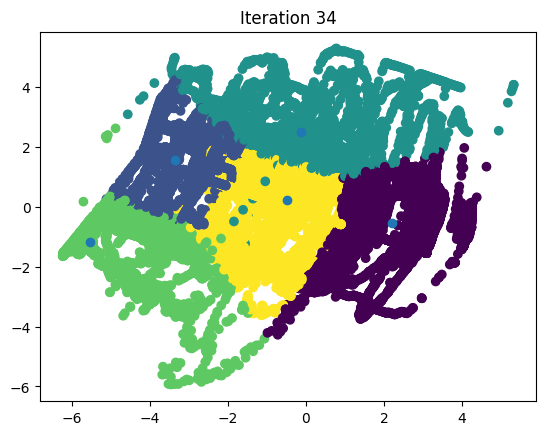

In [89]:
max_iterations = 100
centroid_count = 5

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    
    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, centroid_count)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1
#when new centroids are equilavent to past centroids (indicates that it has stopped shifting)
#update the data to see which label corresponds with each cluster

In [90]:
centroids

,0,1,2,3,4
speedMps,7.952808,1.938007,4.836782,1.361008,5.114180
throttlePercentage,1.959986,1.535989,4.604817,1.003199,1.513747
steeringPercentage,6.057102,5.163185,6.152890,6.036854,6.113718
brakePercentage,1.089384,1.146125,1.005866,5.218545,1.214302


In [91]:
labels.value_counts()

0    24356
4    13777
3     6562
1     4423
2     4089
Name: count, dtype: int64

In [139]:
best_pose[labels == 0][["groupMetadataID"] + features]

KeyError: "['Acceleration'] not in index"

In [93]:
best_pose[labels == 5][["groupMetadataID"] + features]
#shows the data in which cluster they are in, hence there is no cluster 5

,groupMetadataID,speedMps,throttlePercentage,steeringPercentage,brakePercentage


In [94]:
from sklearn.cluster import KMeans

In [95]:
kmeans = KMeans(3)
kmeans.fit(data)

KMeans(n_clusters=3)

In [96]:
pd.DataFrame(kmeans.cluster_centers_, columns=features).T

,0,1,2
speedMps,4.348351,1.645351,7.883973
throttlePercentage,2.099184,1.011204,2.291279
steeringPercentage,5.998781,6.030081,6.056254
brakePercentage,1.213382,5.132792,1.181705


In [97]:
from sklearn.cluster import KMeans

In [101]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
cfs.BinaryDrivingMode(best_pose)

In [128]:
add = ['BinaryDrivingMode', 'Acceleration']

In [135]:
c0= best_pose[labels == 0][['BinaryDrivingMode']+ features]

In [133]:
c1= best_pose[labels == 1][["BinaryDrivingMode"] + features]

In [108]:
c2= best_pose[labels == 2][["BinaryDrivingMode"] + features]

In [109]:
c2.head()

,BinaryDrivingMode,speedMps,throttlePercentage,steeringPercentage,brakePercentage
1311,0,4.15,34.9,-25.925564,0.0
1312,0,4.19,38.4,-26.542604,0.0
1313,0,4.20,39.3,-26.542604,0.0
1314,0,4.25,41.1,-27.247797,0.0
1315,0,4.30,43.9,-27.247797,0.0


In [ ]:
sns.pairplot(c0)

In [ ]:
chasis = pd.read_csv("/home/jle_linux/Desktop/TDMprivate/data/0b72a836-f37e-11ee-bb4e-fb353e7798cd/_apollo_canbus_chassis/0b72a836-f37e-11ee-bb4e-fb353e7798cd_apollo_canbus_chassis.csv")

In [ ]:
chasis.head()

In [ ]:
best_pose.head()

In [ ]:
chasis.head()

In [ ]:
def CalculateVelocity(chassis_df):
    """
    Calculates the velocity based on distance and time in the chassis DataFrame.
    
    Parameters:
    chassis_df (pd.DataFrame): DataFrame containing 'distance' and 'time' columns.
    
    Returns:
    None: The function modifies the DataFrame in place by adding a 'velocity' column.
    """
    
    # Ensure the DataFrame is sorted by time
    chassis_df = chassis_df.sort_values(by='time').reset_index(drop=True)

    # Calculate the difference in distance and time between consecutive rows
    distance_diff = chassis_df['Distance'].diff()  # Change in distance
    time_diff = chassis_df['time'].diff()          # Change in time

    # Calculate velocity and add it as a new column
    chassis_df['velocity'] = distance_diff / time_diff
    
    # Replace NaN values (typically in the first row) with 0 or interpolate if needed
    chassis_df['velocity'].fillna(0, inplace=True)


In [ ]:
chasis = chasis.sort_values( 'time' )

In [ ]:
cfs.DeltaTime(chasis)

In [ ]:
cfs.Distance(chasis)

In [118]:
def Acceleration(time_sorted_chassis_df):
    speedMps_array = np.array(time_sorted_chassis_df['speedMps']) 
    time_array = np.diff(np.array(time_sorted_chassis_df['time'])) * 1e-9 # seconds 
    time_array = np.insert(time_array, 0, time_array[0])

    acceleration_list = [] # meters/second^2
    for index in range(1, len(speedMps_array)):
        acceleration = (speedMps_array[index] - speedMps_array[index - 1]) / time_array[index]
        acceleration_list.append(acceleration)

    acceleration_list = [0] + acceleration_list # Initial acceleration is 0
    time_sorted_chassis_df['Acceleration'] = acceleration_list

In [141]:
Acceleration(best_pose)

In [142]:
best_pose.head()

,brakePercentage,groupMetadataID,drivingMode,speedMps,time,throttlePercentage,steeringPercentage,signal.turnSignal,BinaryDrivingMode,Acceleration
0,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301113165469,0.0,-34.701275,TURN_NONE,0,0.0
1,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301145044093,0.0,-34.701275,TURN_NONE,0,0.0
2,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301187896638,0.0,-34.701275,TURN_NONE,0,0.0
3,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301211437749,0.0,-34.701275,TURN_NONE,0,0.0
4,0.0,06cbdbc0-db4d-11ee-a158-97f8443fd730,COMPLETE_MANUAL,0.0,1693494301254799428,0.0,-34.701275,TURN_NONE,0,0.0


In [138]:
chasis.head()

,brakePercentage,groupMetadataID,drivingMode,speedMps,time,throttlePercentage,steeringPercentage,signal.turnSignal,DeltaTime,Distance,Acceleration
0,0.0,0b72a836-f37e-11ee-bb4e-fb353e7798cd,COMPLETE_MANUAL,3.92,1707420476851932894,17.4,-73.104800,TURN_RIGHT,31966856,0.000000,0.000000
1,0.0,0b72a836-f37e-11ee-bb4e-fb353e7798cd,COMPLETE_MANUAL,3.93,1707420476883899750,17.4,-72.664055,TURN_RIGHT,31966856,0.125310,0.312824
2,0.0,0b72a836-f37e-11ee-bb4e-fb353e7798cd,COMPLETE_MANUAL,3.96,1707420476917887466,17.4,-72.184135,TURN_RIGHT,33987716,0.250940,0.882672
3,0.0,0b72a836-f37e-11ee-bb4e-fb353e7798cd,COMPLETE_MANUAL,3.99,1707420476950430948,17.4,-71.567090,TURN_RIGHT,32543482,0.385531,0.921844
4,0.0,0b72a836-f37e-11ee-bb4e-fb353e7798cd,COMPLETE_MANUAL,4.02,1707420476983802634,17.4,-71.087166,TURN_RIGHT,33371686,0.515380,0.898966


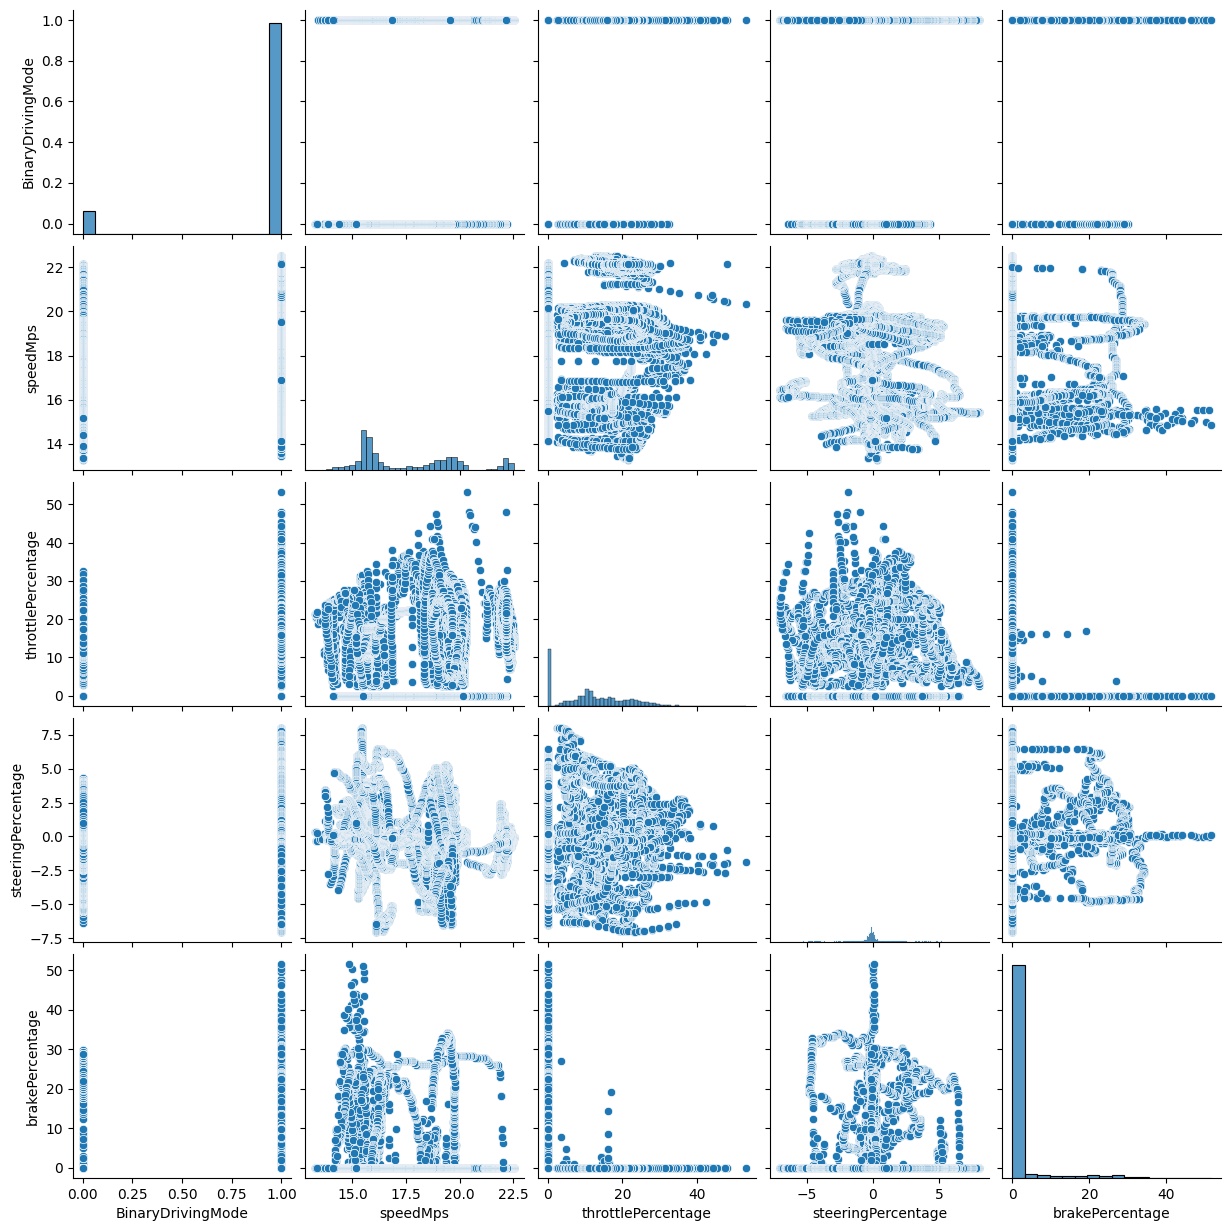

In [114]:
sns.pairplot(c0)

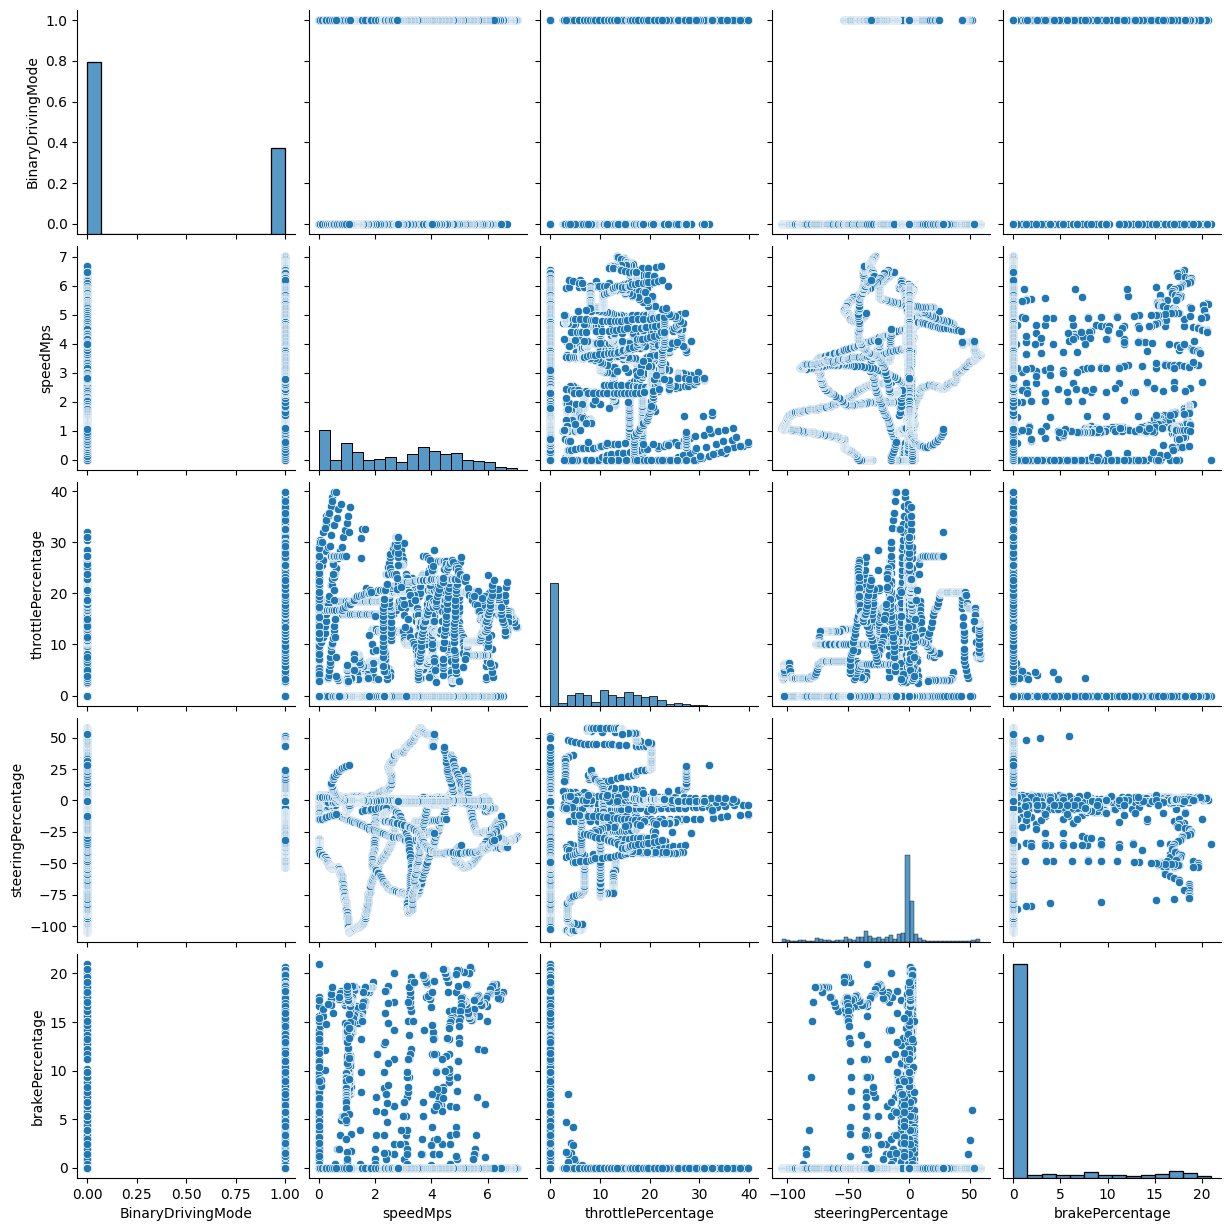

In [115]:
sns.pairplot(c1)

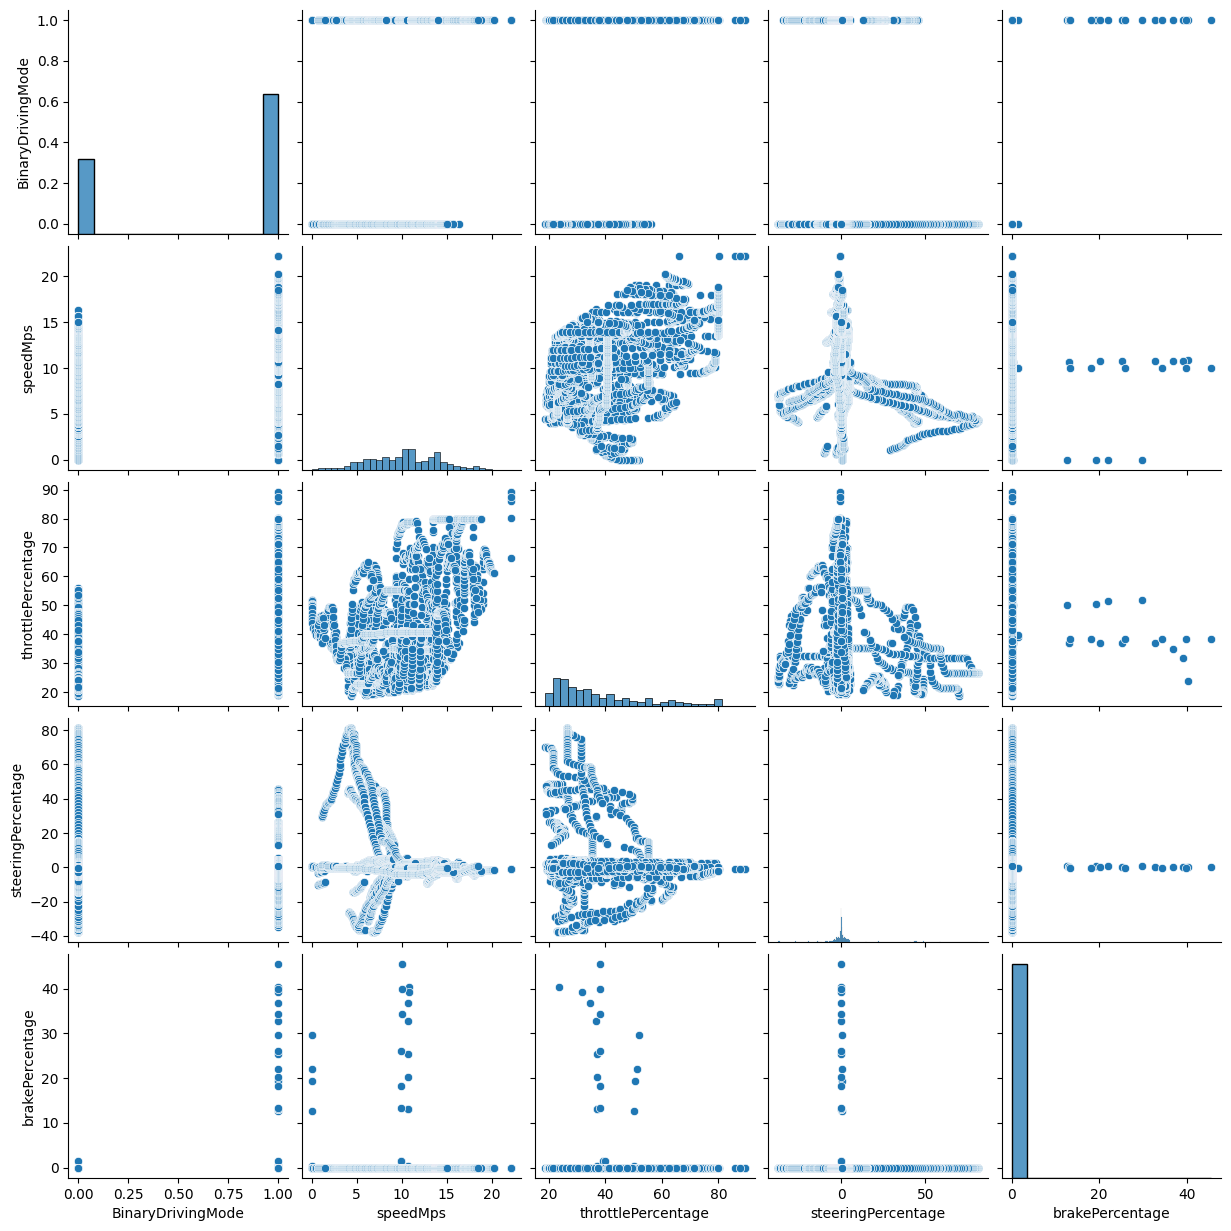

In [116]:
sns.pairplot(c2)

In [ ]:
sns.heatmap(data)

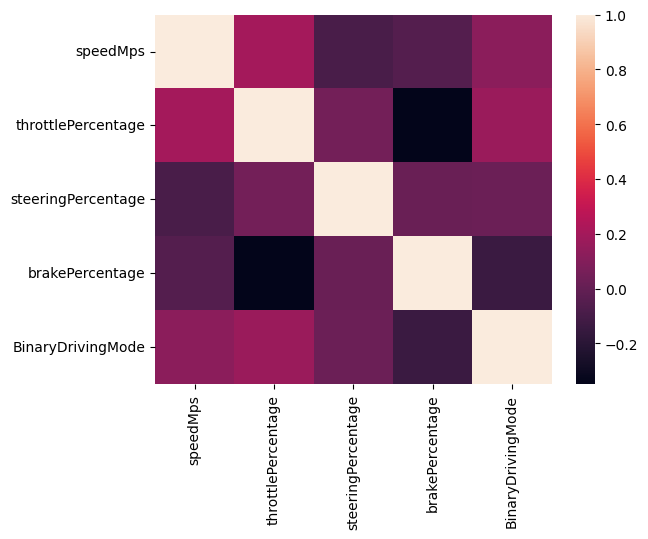

In [156]:
correlation = c0[features].corr(method = 'pearson')
ax = sns.heatmap(correlation)

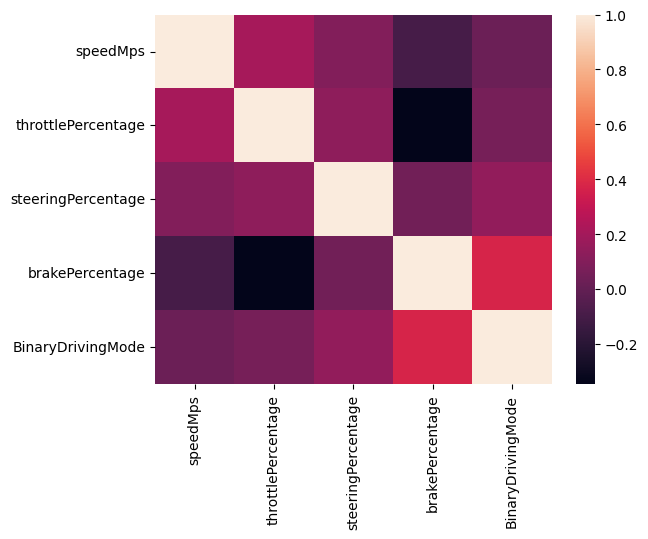

In [157]:
correlation = c1[features].corr(method = 'pearson')
ax = sns.heatmap(correlation)

<Axes: >

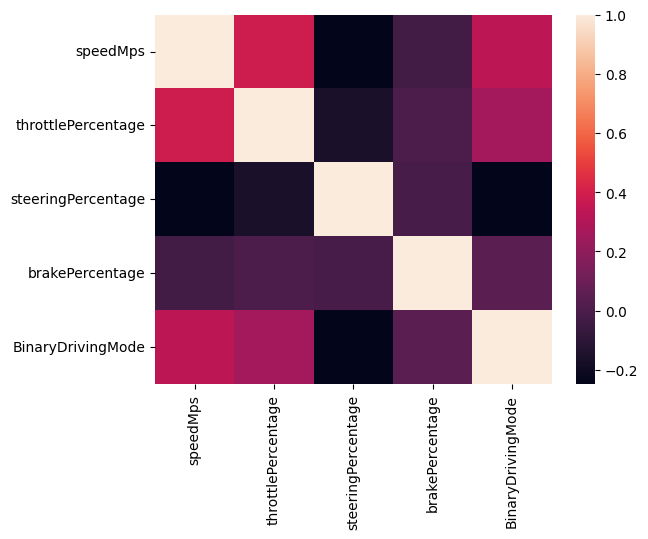

In [158]:
correlation = c2[features].corr(method = 'pearson')
sns.heatmap(correlation)

In [160]:
correlation = chasis[features].corr(method = 'pearson')
sns.heatmap(correlation)

KeyError: "['BinaryDrivingMode'] not in index"

In [153]:
c3= best_pose[labels == 3][["groupMetadataID"] + features]

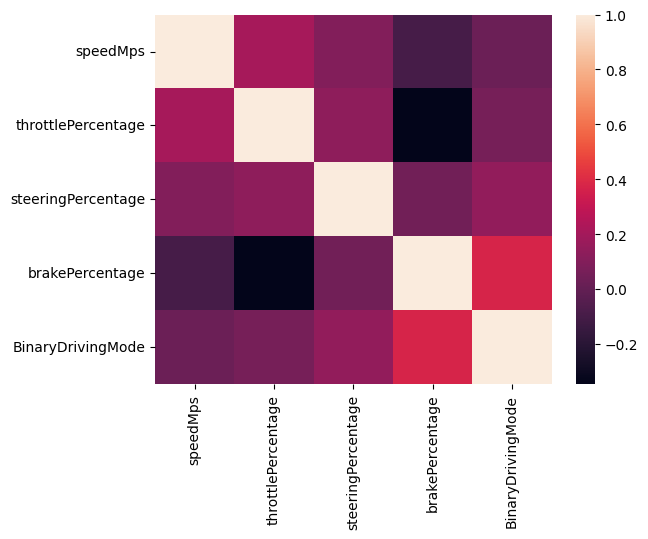

In [161]:
correlation = c1[features].corr(method = 'pearson')
ax = sns.heatmap(correlation)